In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler # Undersampling for Unbalanced Data
from imblearn.over_sampling import SMOTE # Oversampling for Unbalanced Data
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Data Encoders
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
import networkx as nx

In [2]:
df = pd.read_csv("C:/Users/sieji/OneDrive/Documents/NUS/BT4012/bt4012/fraudTrain.csv")
df = pd.concat([df[df["is_fraud"]==0].sample(frac=0.20, random_state=42), df[df["is_fraud"] == 1]])

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265340 entries, 811778 to 1295733
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             265340 non-null  int64  
 1   trans_date_trans_time  265340 non-null  object 
 2   cc_num                 265340 non-null  int64  
 3   merchant               265340 non-null  object 
 4   category               265340 non-null  object 
 5   amt                    265340 non-null  float64
 6   first                  265340 non-null  object 
 7   last                   265340 non-null  object 
 8   gender                 265340 non-null  object 
 9   street                 265340 non-null  object 
 10  city                   265340 non-null  object 
 11  state                  265340 non-null  object 
 12  zip                    265340 non-null  int64  
 13  lat                    265340 non-null  float64
 14  long                   265340 non-n

In [5]:
# Calculate the total number of rows in the DataFrame
total_rows = len(df)

# Calculate the number of fraud (is_fraud=1) and non-fraud (is_fraud=0) rows
fraud_count = df[df["is_fraud"] == 1]["is_fraud"].count()
non_fraud_count = df[df["is_fraud"] == 0]["is_fraud"].count()

# Calculate the proportions
fraud_proportion = fraud_count / total_rows
non_fraud_proportion = non_fraud_count / total_rows

# Print the proportions
print("Proportion of Fraudulent Transactions:", fraud_proportion)
print("Proportion of Non-Fraudulent Transactions:", non_fraud_proportion)


Proportion of Fraudulent Transactions: 0.028288233963970753
Proportion of Non-Fraudulent Transactions: 0.9717117660360293


In [6]:

# def build_graph_bipartite(transaction_data, graph_type=nx.Graph()):

#     # Create a copy of the input DataFrame
#     df = transaction_data.copy()

#     # Create node mappings for credit card numbers and merchants
#     node_mapping = {x: node_id for node_id, x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
#     df["from_node"] = df["cc_num"].apply(lambda x: node_mapping[x])
#     df["to_node"] = df["merchant"].apply(lambda x: node_mapping[x])

#     # Group data by 'from_node', 'to_node', 'amt', and 'is_fraud' columns and calculate sums
#     df = df[['from_node', 'to_node', "amt", "is_fraud"]].groupby(['from_node', 'to_node']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()

#     # Convert 'is_fraud' column to binary values (0 for no fraud, 1 for fraud)
#     df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x > 0 else 0)

#     # Create the graph using NetworkX from the edge list
#     G = nx.from_edgelist(df[["from_node", "to_node"]].values, create_using=graph_type)

#     # Set node attributes for bipartite classification
#     nx.set_node_attributes(G, {x: "credit_card" for x in df["from_node"].unique()}, "bipartite")
#     nx.set_node_attributes(G, {x: "merchant" for x in df["to_node"].unique()}, "bipartite")

#     # Set edge labels and weights
#     edge_labels = {(int(x["from_node"]), int(x["to_node"])): x["is_fraud"] for idx, x in df[["from_node", "to_node", "is_fraud"]].iterrows()}
#     edge_weights = {(int(x["from_node"]), int(x["to_node"])): x["amt"] for idx, x in df[["from_node", "to_node", "amt"]].iterrows()}
#     nx.set_edge_attributes(G, edge_labels, "label")
#     nx.set_edge_attributes(G, edge_weights, "weight")

#     return G

# def build_graph_tripartite(transaction_data, graph_type=nx.Graph()):

#     # Create a copy of the input DataFrame
#     df = transaction_data.copy()

#     # Create node mappings for credit card numbers, merchants, and a third type
#     node_mapping = {x: node_id for node_id, x in enumerate(set(df.index.values.tolist() + df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
#     df["credit_card_node"] = df["cc_num"].apply(lambda x: node_mapping[x])
#     df["merchant_node"] = df["merchant"].apply(lambda x: node_mapping[x])

#     # Create the tripartite graph using NetworkX
#     edge_list = [(x["credit_card_node"], node_mapping[idx]) for idx, x in df.iterrows()] + [(x["merchant_node"], node_mapping[idx]) for idx, x in df.iterrows()]
#     G = nx.from_edgelist(edge_list, create_using=graph_type)

#     # Set node attributes for bipartite classification
#     nx.set_node_attributes(G, {x["credit_card_node"]: "credit_card" for idx, x in df.iterrows()}, "bipartite")
#     nx.set_node_attributes(G, {x["merchant_node"]: "merchant" for idx, x in df.iterrows()}, "bipartite")
#     nx.set_node_attributes(G, {node_mapping[idx]: "third_type" for idx, x in df.iterrows()}, "bipartite")

#     # Set edge labels and weights
#     edge_labels = {(x["credit_card_node"], node_mapping[idx]): x["is_fraud"] for idx, x in df[["credit_card_node", "is_fraud"]].iterrows()}
#     edge_labels.update({(x["merchant_node"], node_mapping[idx]): x["is_fraud"] for idx, x in df[["merchant_node", "is_fraud"]].iterrows()})
#     edge_weights = {(x["credit_card_node"], node_mapping[idx]): x["amt"] for idx, x in df[["credit_card_node", "amt"]].iterrows()}
#     edge_weights.update({(x["merchant_node"], node_mapping[idx]): x["amt"] for idx, x in df[["merchant_node", "amt"]].iterrows()})
#     nx.set_edge_attributes(G, edge_labels, "label")
#     nx.set_edge_attributes(G, edge_weights, "weight")

#     return G


In [7]:

#Dual classification graph creation function
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    # Create graph nodes by mapping unique credit card numbers and merchant IDs
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    
    #Group by 'from', 'to', 'amt', 'is_fraud' columns and calculate sum
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    
    #Convert 'is_fraud' column to 0 and 1
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    #Graph creation
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    #Node property settings
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    #Edge label settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    #Edge weight settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

#Triple classification graph creation function
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

Build the Bipartite and Tripartite graphs

In [8]:
G_bu = build_graph_bipartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_bd = build_graph_bipartite(df, nx.DiGraph(name = 'Bipartite Directed'))
G_tu = build_graph_tripartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_td = build_graph_tripartite(df, nx.DiGraph(name='Tripartite Directed'))

In [9]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

In [10]:

def print_graph_info(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    graph_density = num_edges / (num_nodes * (num_nodes - 1) / 2)  # If the graph is undirected
    average_degree = sum(dict(graph.degree()).values()) / num_nodes

    print("Number of nodes:", num_nodes)
    print("Number of edges:", num_edges)
    print("Graph density:", graph_density)
    print("Average degree:", average_degree)
    print("Number of nodes:", num_nodes)

# Example usage:
# Assuming you have created a graph 'G_bu' using your build_graph function
# Replace 'G_bu' with your specific graph
# ...

# Call the function to print information about the graph
print_graph_info(G_bu)


Number of nodes: 1676
Number of edges: 201725
Graph density: 0.1437146012182524
Average degree: 240.7219570405728
Number of nodes: 1676


In [11]:
print_graph_info(G_tu)

Number of nodes: 267016
Number of edges: 530680
Graph density: 1.4886402974790514e-05
Average degree: 3.974892890313689
Number of nodes: 267016


Plotting distribution of node degrees for both graph structures

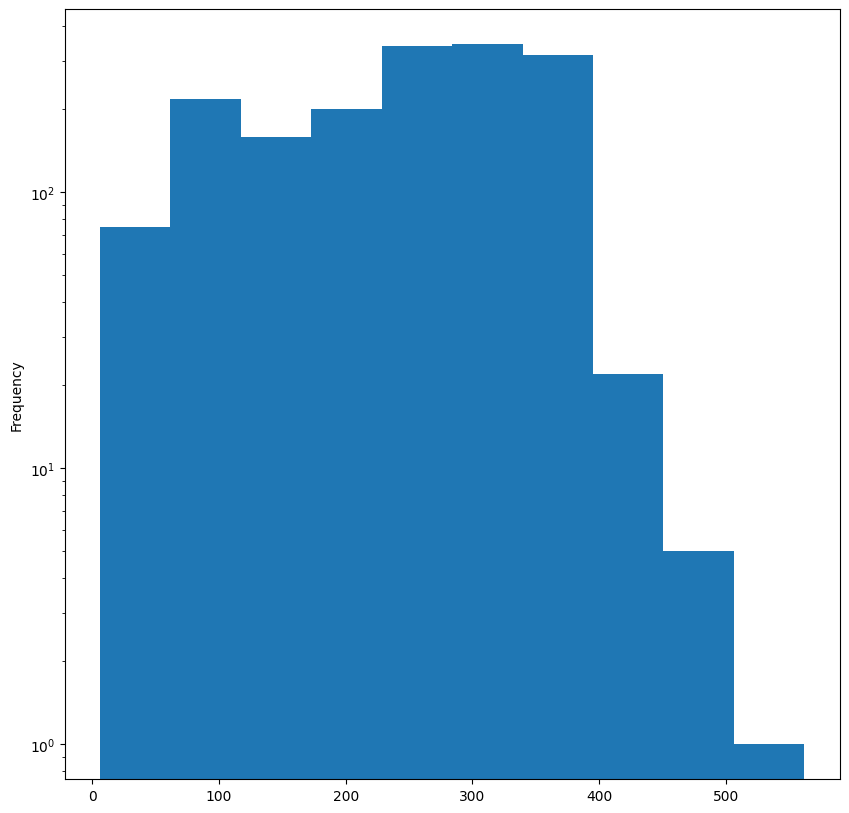

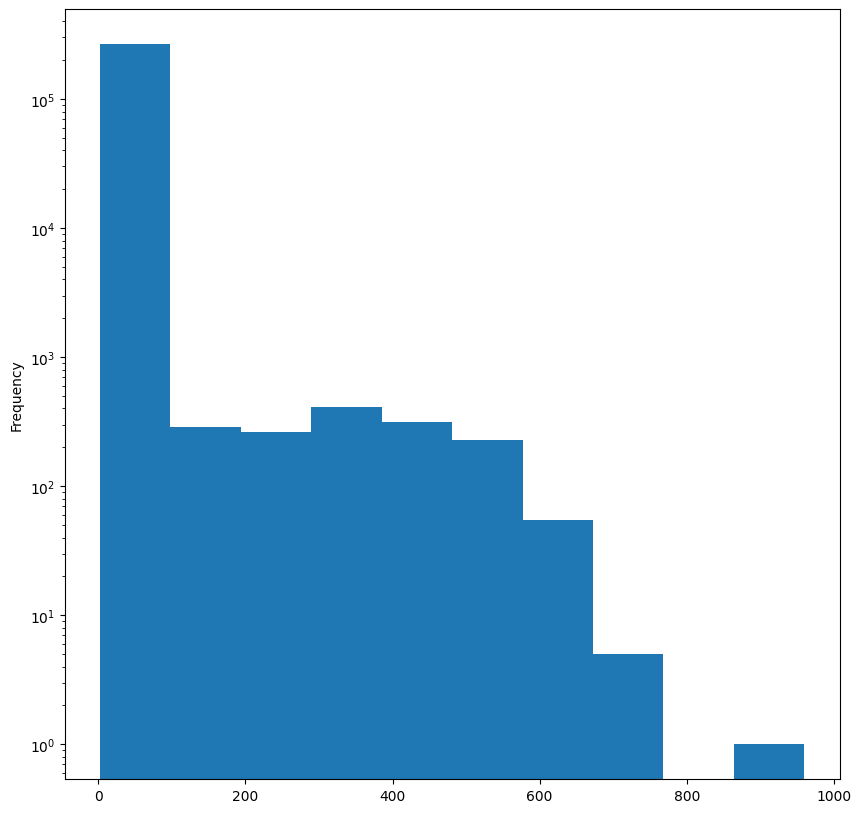

In [12]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    degrees = pd.Series(
        {
            k:v for k,v in nx.degree(G)
        }
    )
    degrees.plot.hist()
    plt.yscale("log")

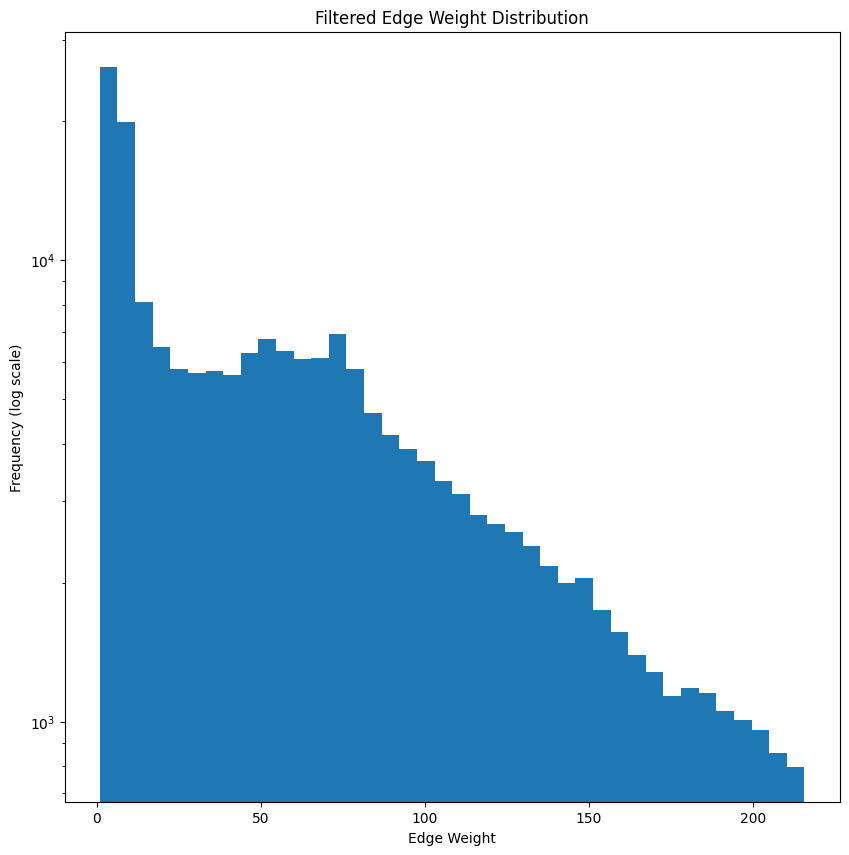

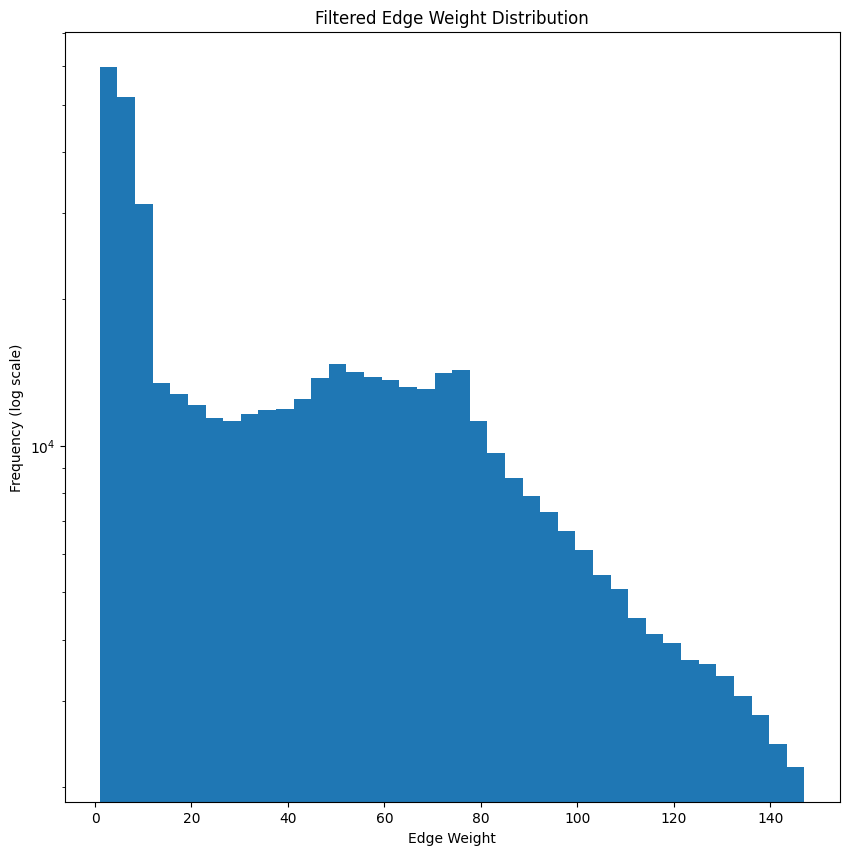

In [13]:
graph_list = [G_bu, G_tu]

# Iterate over each graph
for G in graph_list:
    # Create a pandas Series with edge weights
    all_edge_weights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    
    # Calculate quantiles for edge weights
    quantiles = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9, 1.0])
    
    # Select a quantile range for filtering
    quant_dist = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9])
    
    # Create a filtered Series with edge weights based on the quantile range
    all_edge_weights_filtered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) if d[2]["weight"] < quant_dist[-1]})
    
    # Plot the filtered edge weight distribution using a logarithmic scale
    plt.figure(figsize=(10, 10))
    all_edge_weights_filtered.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency (log scale)')
    plt.title('Filtered Edge Weight Distribution')
    plt.show()


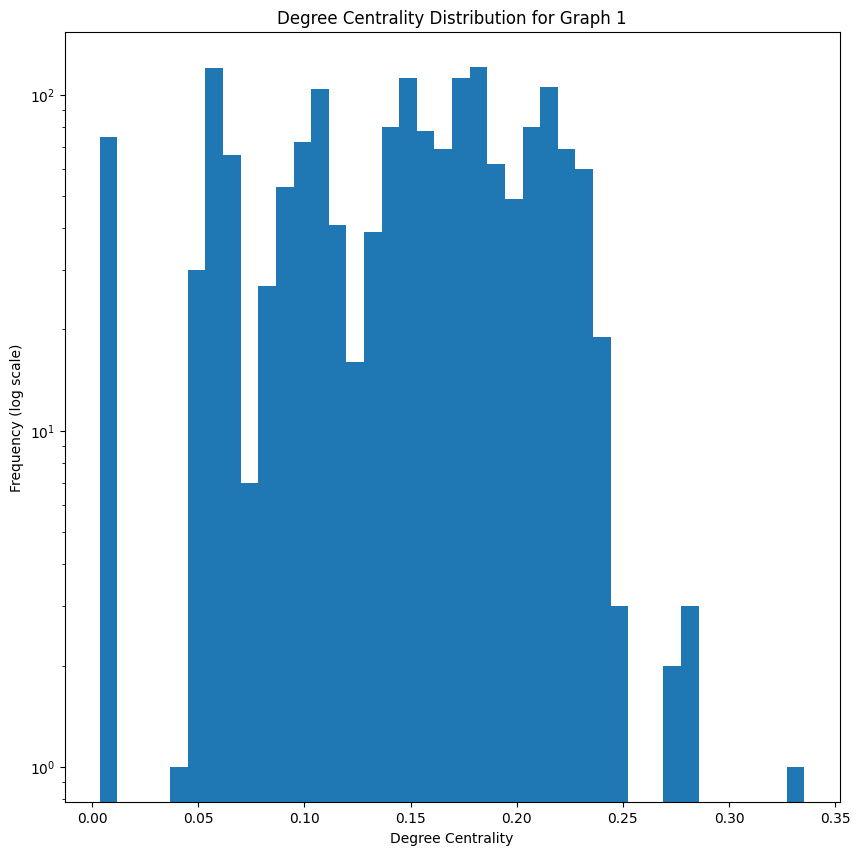

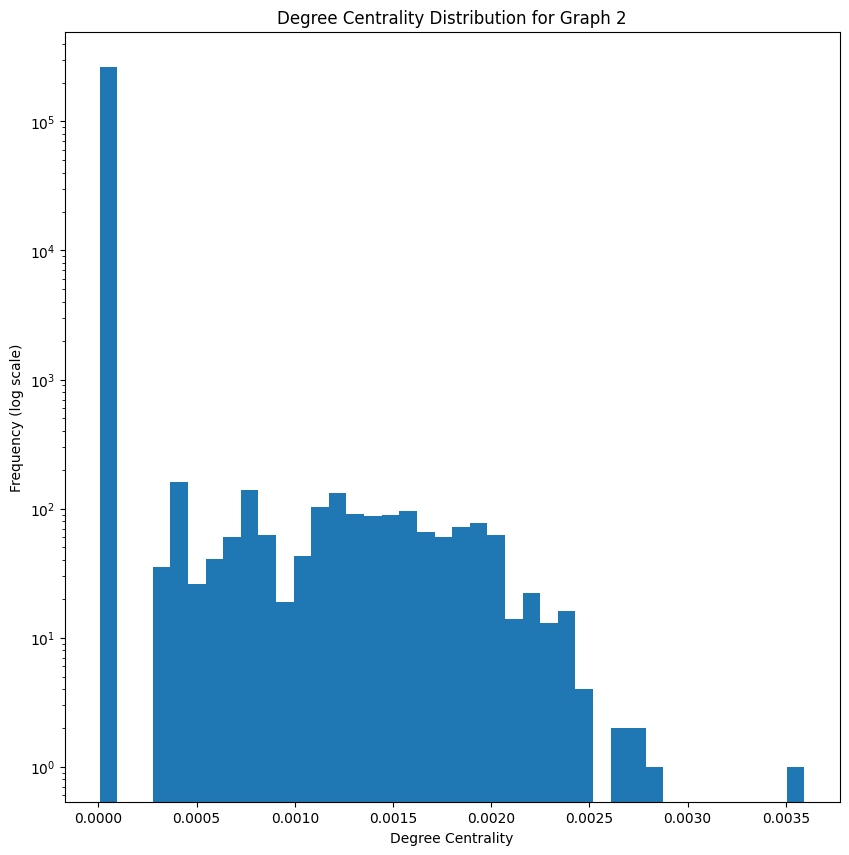

In [14]:
graph_list = [G_bu, G_tu]

# Initialize dictionaries to store degree centrality results for each graph
degree_centrality_results = {}

# Iterate over each graph and plot degree centrality distribution
for i, G in enumerate(graph_list):
    # Calculate degree centrality for the graph
    degree_centrality = nx.degree_centrality(G)
    
    # Convert degree centrality values to a pandas Series
    degree_centrality_series = pd.Series(degree_centrality)
    
    # Plot the degree centrality distribution using a logarithmic scale
    plt.figure(figsize=(10, 10))
    degree_centrality_series.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Degree Centrality Distribution for Graph {i + 1}')
    plt.show()

In [15]:
import community
parts = community.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

1     493
6     293
4     237
9     165
10     95
8      90
0      71
2      56
7      51
5      50
3      50
11     25
Name: count, dtype: int64

The results indicate that the network can be partitioned into 18 distinct communities. These communities vary in size, with the largest community having 170 nodes and the smallest having 21 nodes. The varying sizes suggest that some groups of nodes are more tightly connected or influential than others within the network

<Axes: ylabel='Frequency'>

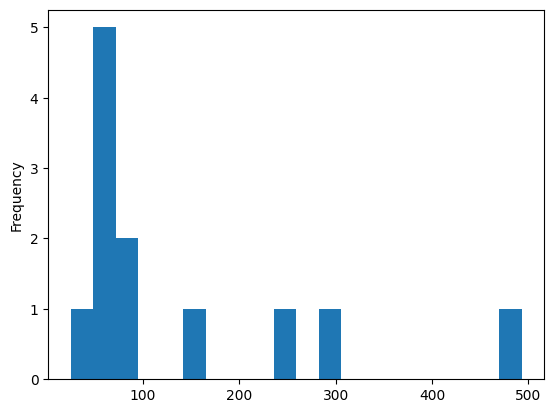

In [16]:
communities.value_counts().plot.hist(bins=20)

In [17]:
community_ratios = {}

for community_id in communities.unique():
    subgraph = nx.subgraph(G_bu, communities[communities == community_id].index)
    total_edges = subgraph.number_of_edges()
    fraud_edges = sum(nx.get_edge_attributes(subgraph, "label").values())

    ratio = 0 if total_edges == 0 else (fraud_edges / total_edges) * 100
    community_ratios[community_id] = ratio
pd.Series(community_ratios).sort_values(ascending=False)


2     29.383886
8     25.536481
10    25.403226
11    22.807018
0     22.327044
7     20.737327
3     18.644068
9     15.540541
5     15.492958
6      4.662686
4      1.790073
1      1.694119
dtype: float64

The above is the fraudulent percentage provided at the community level. We can further plot the node-induced subgraphs for a particular community. In the code below, gId indicates the Community ID.

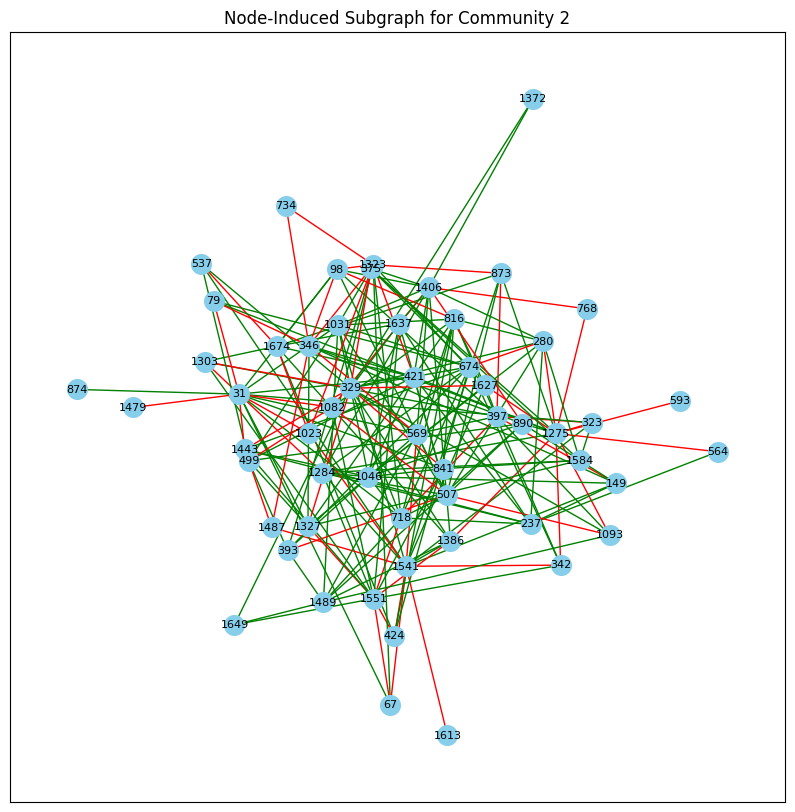

In [24]:
def plot_community_subgraph(graph, community_id):
    # Create a subgraph for the specified community
    subgraph = nx.subgraph(graph, communities[communities == community_id].index)
    
    # Create lists to store edge colors based on their type
    edge_colors = ["green" if subgraph.edges[edge]["label"] == 0 else "red" for edge in subgraph.edges()]

    # Plot the subgraph with edge colors
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgraph, seed=42)  # You can use different layout algorithms

    # Draw nodes with labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color="skyblue")
    nx.draw_networkx_labels(subgraph, pos, font_size=8)

    # Draw edges with specified colors
    nx.draw_networkx_edges(subgraph, pos, width=1, edge_color=edge_colors)

    plt.title(f"Node-Induced Subgraph for Community {community_id}")
    plt.show()

# Usage: Plot the subgraph for Community 2
plot_community_subgraph(G_bu, community_id=2)

Even though community 6 had the highest percentage of fraud transactions, it seems the volume density is little. Let us plot the community with the second highest percentage.

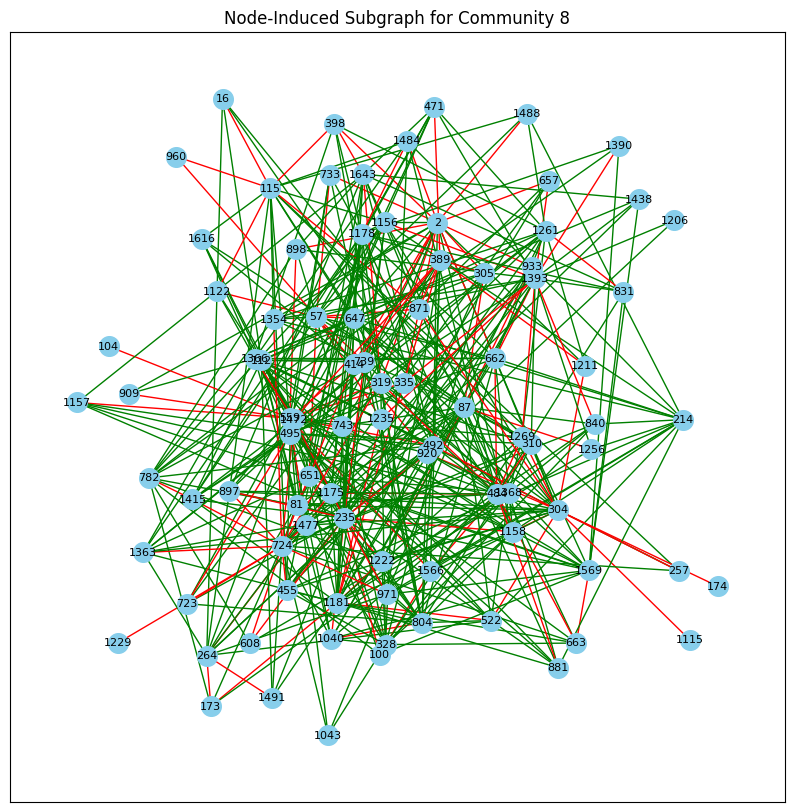

In [25]:
# Usage: Plot the subgraph for Community 8
plot_community_subgraph(G_bu, community_id=8)


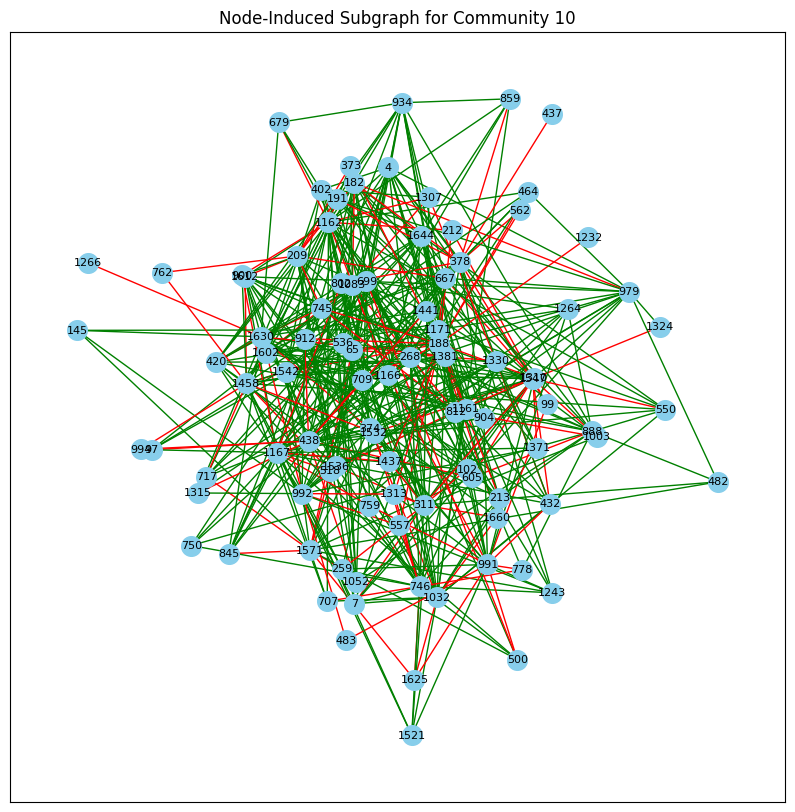

In [26]:
# Usage: Plot the subgraph for Community 10
plot_community_subgraph(G_bu, community_id=10)


Now, we will plot for the community with the least fraud percentage

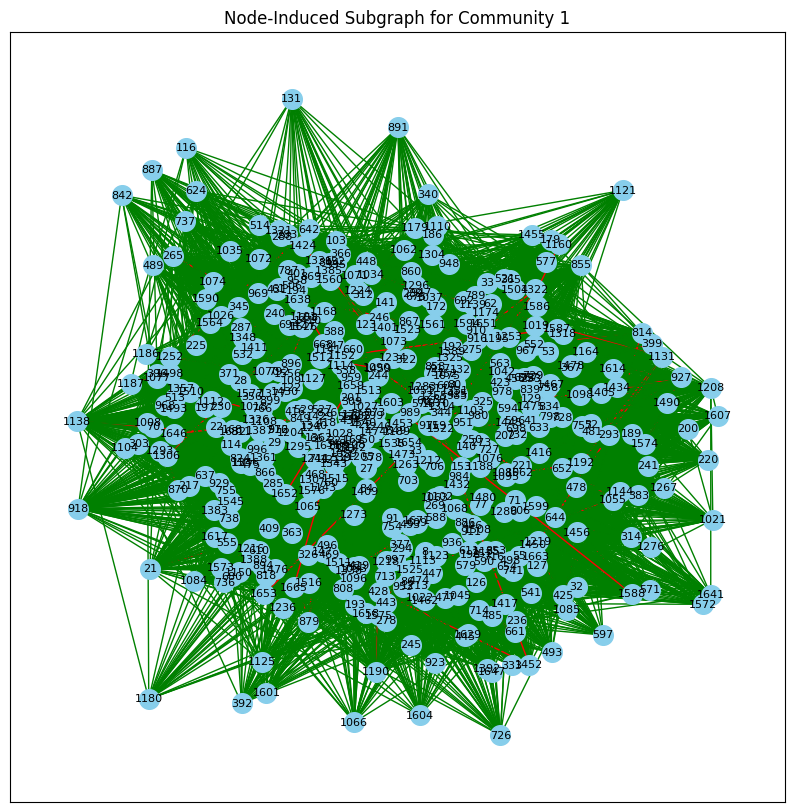

In [27]:
# Usage: Plot the subgraph for Community 1
plot_community_subgraph(G_bu, community_id=1)


###WRITE DOWN ANALYSIS OF GRAPH EDA HERE

Handling Class Imbalance

In [35]:
from sklearn.utils import resample

# Split the DataFrame into majority and minority classes
df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

# Determine the number of samples to downsample to (e.g., to match the size of the minority class)
num_samples = len(df_minority)

# Downsample the majority class to match the number of samples in the minority class
df_maj_downsampled = resample(df_majority, n_samples=num_samples, random_state=42)

# Concatenate the downsampled majority class with the original minority class
df_downsampled = pd.concat([df_minority, df_maj_downsampled])

# Print the class distribution to verify downsampling
print(df_downsampled.is_fraud.value_counts())

# Build the bipartite graph from the downsampled DataFrame
G_down = build_graph_bipartite(df_downsampled)

is_fraud
1    7506
0    7506
Name: count, dtype: int64


Performing Train Test Split

In [36]:
from sklearn.model_selection import train_test_split

train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))),
                                                                      list(nx.get_edge_attributes(G_down, "label").values()),
                                                                      test_size = 0.20,
                                                                      random_state=42)

In [38]:
# Create a list of edges for the train set
edgs = list(G_down.edges)

# Create the train_graph by extracting nodes and edges corresponding to the train set
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()

# Add nodes that are in the original graph but not in the train_graph
train_graph.add_nodes_from(set(G_down.nodes) - set(train_graph.nodes))


In [46]:
from node2vec import Node2Vec

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


In [49]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn import metrics

embedding_classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]

for embedding_class in embedding_classes:
    embeddings_train = embedding_class(keyed_vectors=model_train.wv)
    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_classifier.fit(train_embeddings, train_labels)

    y_pred = rf_classifier.predict(test_embeddings)
    print(embedding_class)
    print('Precision:', metrics.precision_score(test_labels, y_pred))
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.6836734693877551
Recall: 0.046206896551724136
F1-Score: 0.08656330749354005
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.6987870619946092
Recall: 0.7151724137931035
F1-Score: 0.7068847989093389
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.7241379310344828
Recall: 0.028965517241379312
F1-Score: 0.0557029177718833
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.7213114754098361
Recall: 0.030344827586206897
F1-Score: 0.05823957643944407


It seems the Average Embedding method gives  the best evaluation metric scores with 70.6% F1-score. We will now improve the perfomance metrics by doing hyperparamater tuning

In [52]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import AverageEmbedder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Create the AverageEmbedder
embedding_method = AverageEmbedder(keyed_vectors=model_train.wv)

# Create training and testing embeddings
train_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
test_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]

# Define a smaller hyperparameter grid for faster tuning
param_grid = {
    'n_estimators': [100, 500], 
    'max_depth': [None, 10],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a GridSearchCV instance with F1-Score as the scoring metric
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='f1', cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(train_embeddings, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions with the best model
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(test_embeddings)

# Calculate the F1-Score of the best model
f1 = f1_score(test_labels, y_pred)
print('Best F1-Score:', f1)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best F1-Score: 0.7116104868913857


After tuning, the best F1-score achieved is 71.1%. A slight increase from the initial attempt